Rede Neural Convolucional Para Classificação de Sentimentos

In [1]:
# Importação das bibliotecas
import numpy as np
import math
import re # expressões regulares
import pandas as pd
from bs4 import BeautifulSoup # pré prcessamentos em texto
from google.colab import drive
import seaborn as sns
import spacy as sp # Processamento de linguagem natural
import string # pré eprocessamento
import random # numeros aleatórios
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
# Montando o drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Lista com as colunas da base de dados
lista = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [4]:
# Carregando a base de dados. header pq não tem cabeçalho, names para nome das colunas
treino = pd.read_csv('/content/drive/MyDrive/trainingandtestdata/train.csv', header = None,
                         names = lista, engine = 'python', encoding = 'latin1')

In [5]:
# Observando os registros e colunas
treino.shape

(1600000, 6)

In [6]:
# Observando a base de dados
treino

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
# Contando os sentimentos únicos
treino.sentiment.unique()

array([0, 4])

In [8]:
# base de dados de teste
teste = pd.read_csv("/content/drive/MyDrive/trainingandtestdata/test.csv",
                    header=None,
                    names=lista,
                    engine="python",
                    encoding="latin1")

In [9]:
teste.shape

(498, 6)

In [10]:
# Sentimentos únicos 3 classes, positivo, negativo e neutro
teste.sentiment.unique()

array([4, 0, 2])

In [11]:
# Apagando colunas que não serão úteis
treino.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [12]:
# Observando que ficou somente sentimento e texto
treino.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
# criando variável para os textos e values para transformar para numpy array
x = treino.iloc[:, 1].values

In [14]:
# Observando
x

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [15]:
# Observando se a conversão foi feita
type(x)

numpy.ndarray

In [16]:
# Variável para os sentimentos
y = treino.iloc[:, 0].values

In [17]:
y

array([0, 0, 0, ..., 4, 4, 4])

In [18]:
# Importação para dividir a base de dados x e y treinamento _ teste
from sklearn.model_selection import train_test_split
x, _, y, _ = train_test_split(x, y, test_size = 0.85, stratify = y) # retirar 85% da base de dados stratify para balancear as classes

In [19]:
# Observando, x e y precisam estar balanceados
x.shape

(240000,)

In [20]:
y.shape

(240000,)

In [21]:
# contagem dos valores das classes
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [25]:
def tweets_ok(tweet): # função para limpeza dos dados
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) # removendo o @ e substituindo por um espaço em branco
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet) # removendo a url
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) # retirando numeros
  tweet = re.sub(r" +", ' ', tweet) # retirando espaços em branco
  return tweet

In [26]:
# testando um texto da base de dados
texto = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [27]:
texto = tweets_ok(texto)
texto

<ipython-input-25-4cff1b55af01>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [28]:
# variável para remover stopwords
nlp = sp.load('en_core_web_sm')
nlp

In [29]:
# criando a variável
stop_words = sp.lang.en.STOP_WORDS

In [30]:
# observando as palavras que podem ser removidas
print(stop_words)

{'than', 'anywhere', 'eleven', 'not', 'became', 'mine', 'therein', 'thereby', 'per', 'various', 'n‘t', 'afterwards', 'neither', 'enough', 'meanwhile', 'beyond', 'becomes', 'regarding', 'by', 'noone', 'whose', 'her', 'me', 'latter', 'himself', 'say', 'any', 'us', 'we', 'more', 're', 'front', 'side', 'also', 'hereby', 'where', 'third', 'somehow', '’d', 'under', 'those', 'which', 'wherein', 'ever', 'my', 'whenever', 'because', 'then', 'still', '’s', 'if', 'both', "'s", 'ourselves', 'someone', 'until', "'ll", 'least', 'be', 'nine', 'of', 'get', 'too', 'make', 'top', 'whether', 'even', 'back', 'quite', 'first', 'one', 'fifteen', 'within', 'perhaps', 'but', 'either', 'must', 'who', 'using', 'sometimes', '‘s', 'or', 'against', 'seem', 'such', 'was', "n't", 'thru', 'everywhere', 'except', 'among', 'always', 'a', 'before', 'after', 'between', 'yours', 'seeming', 'while', "'re", 'their', 'bottom', 'on', 'last', 'amount', 'whereafter', 'hundred', 'been', 'forty', 'nowhere', 'you', 'due', 'in', 'w

In [31]:
# observando a quantidade de stopwords
len(stop_words)

326

In [32]:
def tweets_ok2(tweet):
  tweet = tweet.lower() # convertendo para minusculo
  doc = nlp(tweet) # nlp para o formato do processamento

  palavras = [] # lista para armazenar as palavras
  for token in doc: # percorrendo as palavras
    palavras.append(token.text) # add a palavra
  # removendo as stopwords
  palavras = [word for word in palavras if word not in stop_words and word not in string.punctuation]
  palavras = ' '.join([str(element) for element in palavras]) # retornando no formato string

  return palavras

In [33]:
# observando os resultados
texto2 = tweets_ok2(texto)
texto2

'  awww s bummer shoulda got david carr day d'

In [34]:
# Aplicando as funções na base de dados
dados = [tweets_ok2(tweets_ok(tweet)) for tweet in x]

<ipython-input-25-4cff1b55af01>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


In [35]:
# Loop para testar alguns registros com frases aleatórias
for _ in range(10):
  print(dados[random.randint(0, len(dados) - 1)])

  know
justinsmommy don t think feels good m letting cio know sick
  crispin glover marty mcfly ... according google info
god awful traffic westside atl taken transit
s time white ink tat touched fading away
  thanks
s raining let smelly arse crying dog inside ... words dad fur coat outside
follow ll entertained check youtube cressferriera
guys fl privalagd wiv presence wsnt gna cum bt cos feel nosy maths monday
wish day today hate suite tease y o s ugh


In [36]:
# Criando nova variável para y
dadosy = y

In [37]:
# Transformando a classe 4 para 1 porque a função sigmoid retorna valor 0 ou 1
dadosy[dadosy == 4] = 1

In [38]:
# Observando a transformação
dadosy

array([1, 1, 0, ..., 1, 1, 1])

In [39]:
# Confirmando
np.unique(dadosy)

array([0, 1])

In [41]:
# tokenização para transformar as palavras em numeros
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(dados, target_vocab_size=2**16)

In [42]:
# Observando o tamanho do vocabulário
tokenizer.vocab_size

52812

In [43]:
# palavras selecionadas
print(tokenizer.subwords)

['  ', 's_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'u_', 'don_', ' ...', 'work_', 'today_', 'time_', 'know_', 'new_', 'll_', 'think_', 'want_', 'oh_', 'lol_', 'need_', 'thanks_', 'hope_', 'night_', 'home_', 've_', 'feel_', 'great_', 'miss_', 'd_', ' .... ', 'morning_', 'twitter_', 'lol', 'day', 'wish_', 'na_', 'getting_', 'gon_', 'today', 'happy_', 'bad_', 'watching_', 'tomorrow_', 'sorry_', 'haha_', 'way_', ' ..', 'come_', 'didn_', 'nice_', 'sad_', 'sleep_', 'yeah_', 'work', 'fun_', 'n_', 'wait_', 'hate_', 'hey_', 'right_', 'people_', 'better_', 'bed_', 'tonight_', 'yes_', 'school_', 'having_', 'little_', 'wanna_', 'y_', 'week_', 'long_', 'days_', 'let_', 'best_', 'thank_', 'watch_', 'feeling_', 'working_', 'time', 'awesome_', 'won_', 'e_', 'o_', 'looking_', 'ok_', 'good', 'find_', 'ur_', 'tomorrow', 'went_', 'ready_', 'r_', 'night', 'sure_', 'weekend_', 'look_', 'tired_', 'man_', 'life_', 'trying_', 'pretty_', 'omg_', 'maybe_', 'guys

In [45]:
# Observando o id de uma frase, id para cada palavra
ids = tokenizer.encode('i love you')
ids

[276, 13, 3205]

In [46]:
# Fazendo o processo inverso a nível de teste
texto = tokenizer.decode(ids)
texto

'i love you'

In [47]:
# Criando variavel para codificar sentenças
dados1 = [tokenizer.encode(sentence) for sentence in dados]

In [48]:
# Observando os textos transformados
for _ in range(10):
  print(dados1[random.randint(0, len(dados1) - 1)])

[1, 246, 2681, 1949, 728, 86, 1686, 9485]
[40275, 6861, 4, 1836, 7, 198, 40, 5, 6, 101]
[1, 13942, 24069, 3, 327, 14116, 74, 6, 30, 134, 7183, 8504]
[1, 35, 351, 418, 46880, 2, 65, 318, 4265]
[1117, 9456, 1310]
[2998, 376, 57, 207, 2116, 7551, 3, 74, 75, 4129, 487, 484]
[230, 2335, 28583]
[44, 99, 10, 205, 2775, 335, 409, 1552, 772]
[1, 110, 8426, 34, 19, 3, 11, 1056, 164, 13488, 197, 28656, 25816, 52588, 40302, 2, 43368, 30047]
[1, 110, 20, 2083, 256, 5276, 5, 15, 4, 172, 6736]


In [49]:
# Padding para preencher as sentenças e deixar com o mesmo tamanho
# Observando a sentença com maior tamanho
max_tam = max([len(sentence) for sentence in dados1])
max_tam

65

In [50]:
# Fazendo o preenchimento das sentenças
dados1 = tf.keras.preprocessing.sequence.pad_sequences(dados1,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_tam)

In [51]:
# Observando a transformação
for _ in range(10):
  print(dados1[random.randint(0, len(dados1) - 1)])

[ 753  140   17 2904    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[    1   255 16054  3630     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[    1 29193   116     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     

In [52]:
# Dividindo a base de dados em treino e teste 70% para treino e 30% para teste
treino_inputs, teste_inputs, treino_labels, teste_labels = train_test_split(dados1,
                                                                        dadosy,
                                                                        test_size=0.3,
                                                                        stratify = dadosy)

In [53]:
# Observando na posição 0
treino_inputs[0]

array([ 2496,     7, 38262,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [54]:
# Observando os registros
treino_inputs.shape

(168000, 65)

In [55]:
treino_labels.shape

(168000,)

In [56]:
teste_inputs.shape

(72000, 65)

In [57]:
teste_labels.shape

(72000,)

In [58]:
class DCNN(tf.keras.Model): # definição em formato de classe

  def __init__(self,         # se refere a um objeto e não a classe
               vocab_size,   # tamanho do vacabulario
               emb_dim=128,  # 128 tamanho padrão da matriz embedding
               nb_filters=50,# numero de filtros para cada dimensão 50 valor padrão
               ffn_units=512,# rede neural densa no final 512
               nb_classes=2, # numero de clases 2 positivo ou negativo
               dropout_rate=0.1, # dropout para evitar o overfitting vai zerar 10% dos neuronios
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name) # chamando o método construtor da classe model
    # definindo as camadas
    self.embedding = layers.Embedding(vocab_size, emb_dim) # gerando nova matriz

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu') # objeto bigrama

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D() # camada de pooling para pegar o maior valor dentro do vetor
    # camada densa
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu') # units numero de neuronios na camada escondida
    self.dropout = layers.Dropout(rate = dropout_rate)                  # rate é a qtd de neuronios que será zerada 10%
    if nb_classes == 2: # camada de saída
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training): # função para conectar todos os elementos
    x = self.embedding(inputs)      # x recebe embedding que recebe as entradas
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)
    # concatenando os valores retornados
    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged) # concatenando a camada densa com merged
    merged = self.dropout(merged, training)
    output = self.last_dense(merged) # camada de saída

    return output

In [59]:
# Configurando alguns parâmetros
vocab_size = tokenizer.vocab_size
vocab_size

52812

In [60]:
# definindo valores
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(treino_labels))
nb_classes
dropout_rate = 0.2
nb_epochs = 5 # numero de épocas no treinamento

In [61]:
# Objeto para instanciar a classe dcnn
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [62]:
# Compilando o modelo
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
# Salvando a rede neural para não carregar novamente
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [66]:
# Iniciando o treinamento
history = Dcnn.fit(treino_inputs, treino_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)


Epoch 1/5
2363/2363 [==============================] - 868s 366ms/step - loss: 0.5032 - accuracy: 0.7514 - val_loss: 0.4793 - val_accuracy: 0.7673
Epoch 2/5
2363/2363 [==============================] - 850s 360ms/step - loss: 0.3607 - accuracy: 0.8408 - val_loss: 0.5253 - val_accuracy: 0.7532
Epoch 3/5
2363/2363 [==============================] - 835s 354ms/step - loss: 0.1863 - accuracy: 0.9231 - val_loss: 0.7416 - val_accuracy: 0.7435
Epoch 4/5
2363/2363 [==============================] - 831s 351ms/step - loss: 0.0980 - accuracy: 0.9600 - val_loss: 0.9988 - val_accuracy: 0.7319
Epoch 5/5
2363/2363 [==============================] - 826s 349ms/step - loss: 0.0657 - accuracy: 0.9728 - val_loss: 1.2700 - val_accuracy: 0.7188


In [67]:
# Avaliando o modelo, atributos previsores e as respostas corretas da base de dados de teste
resultados = Dcnn.evaluate(teste_inputs, teste_labels, batch_size=batch_size)
print(resultados)

1125/1125 [==============================] - 57s 51ms/step - loss: 1.2492 - accuracy: 0.7247
[1.2492402791976929, 0.7246805429458618]


In [68]:
# Fazendo previsões
prev = Dcnn.predict(teste_inputs)

2250/2250 [==============================] - 47s 21ms/step


In [69]:
# Observando quanto mais proximo de 0 classifica 0
# Quanto mais proximo de 1 classifica 1
prev

array([[5.0515860e-01],
       [9.9201822e-01],
       [9.4682217e-01],
       ...,
       [5.8751136e-01],
       [6.6890971e-07],
       [9.2560297e-01]], dtype=float32)

In [70]:
# se > 0.5 recebe 1 senão 0
prev = (prev > 0.5)

In [71]:
# observando
prev

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [72]:
# comparando com os valores reais
teste_labels

array([1, 1, 1, ..., 1, 0, 0])

In [73]:
# Importando bilioteca para gerar a matriz de confusão
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(teste_labels, prev)
matriz

array([[25913, 10087],
       [ 9736, 26264]])

<Axes: >

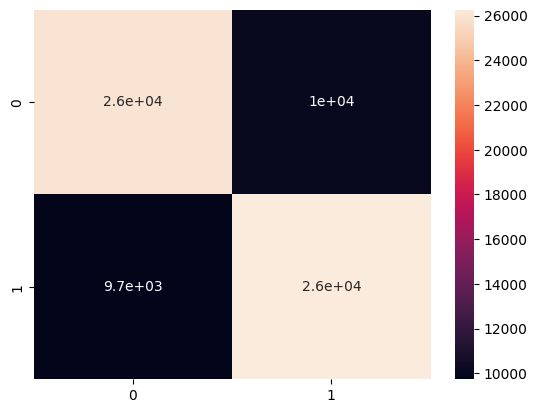

In [74]:
# Visualizando a matriz de confusão
sns.heatmap(matriz, annot=True)

In [75]:
# Histórico de execução da base de treino e teste
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

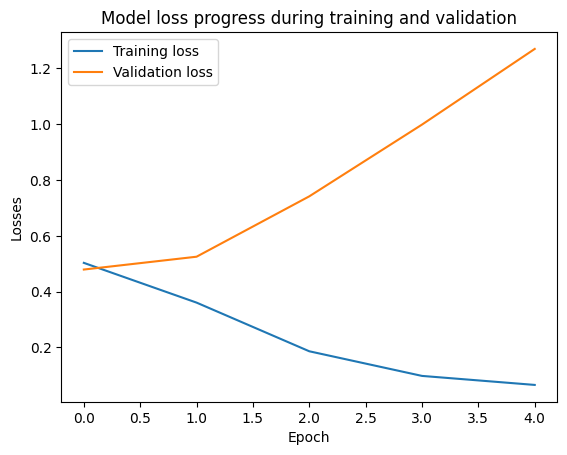

In [76]:
# Gerando gráfico com erro na base de treino e de teste
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

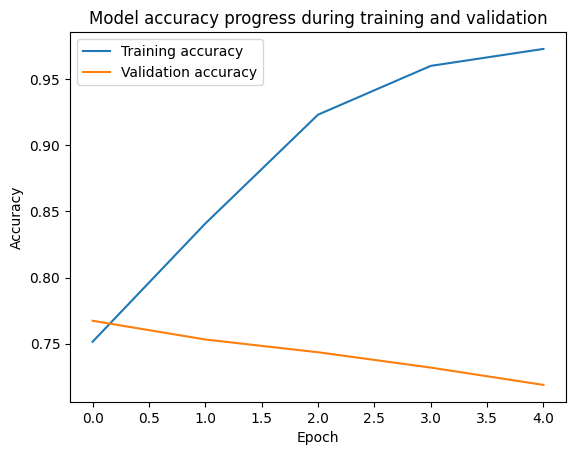

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

In [80]:
# Fazendo uma previsão
prev1 = 'you are beautiful'
prev1 = tokenizer.encode(prev1)
prev1

[4189, 8973, 1343]

In [81]:
# Observando o resultado
Dcnn(np.array([prev1]), training=False).numpy()

array([[0.9986757]], dtype=float32)

In [83]:
# Fazendo uma previsão
prev2 = 'you are crazy'
prev2 = tokenizer.encode(prev2)
prev2

[4189, 8973, 1342]

In [84]:
# Observando o resultado
Dcnn(np.array([prev2]), training=False).numpy()

array([[0.01006202]], dtype=float32)

In [86]:
# Fazendo uma previsão
prev3 = 'will you marry me'
prev3 = tokenizer.encode(prev3)
prev3

[12364, 4189, 4633, 2761]

In [87]:
# Observando o resultado
Dcnn(np.array([prev3]), training=False).numpy()

array([[0.9999998]], dtype=float32)